In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  # データ可視化のための基本的なグラフ描画ライブラリ
import seaborn as sns  # 高機能な統計グラフを描画するライブラリ
from sklearn.preprocessing import LabelEncoder  # カテゴリ変数を数値に変換するエンコーダ
from sklearn.model_selection import StratifiedKFold  # 層化K分割交差検証を行うクラス
from sklearn.metrics import roc_auc_score  # ROC AUCスコアを計算する評価指標

In [3]:
df = pd.read_csv('data.csv')
df.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,RemoteWork,MonthlyIncome,StressRating,WelfareBenefits,InHouseFacility,ExternalFacility,ExtendedLeave,FlexibleWork,StressSelfReported,Year
0,41,Yes,Travel_Rarely,Sales,1,2,Life Sciences,1,1,2,...,1,5224,4,1,0,0,0,0,1,2023
1,49,No,Travel_Frequently,Research & Development,8,1,Life Sciences,1,2,3,...,3,6863,2,4,1,0,0,1,1,2023
2,37,Yes,Travel_Rarely,Research & Development,2,2,Other,1,4,4,...,2,7612,3,2,1,0,0,0,1,2023
3,33,No,Travel_Frequently,Research & Development,3,4,Life Sciences,1,5,4,...,2,11245,1,4,1,1,1,1,1,2023
4,27,No,Travel_Rarely,Research & Development,2,1,Medical,1,7,1,...,2,3029,3,2,0,0,0,0,3,2023


In [4]:
df['Year'].value_counts()

Year
2023    1176
2024     294
Name: count, dtype: int64

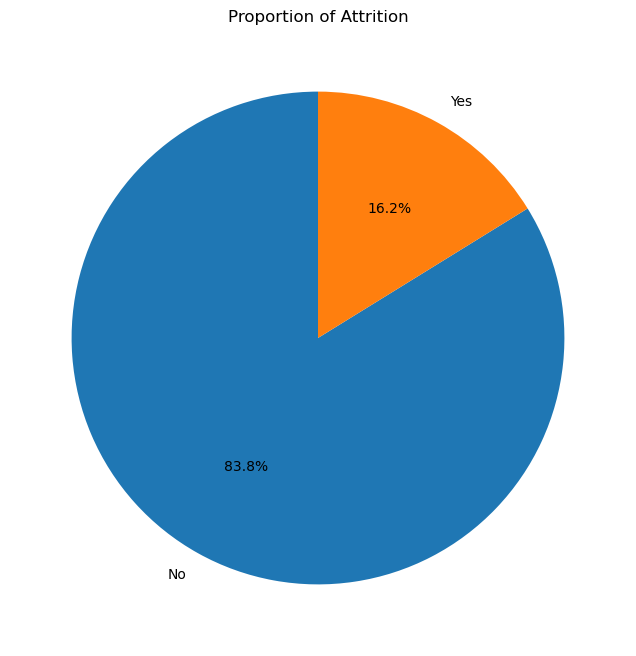

In [5]:
attrition_counts = df['Attrition'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(attrition_counts, labels=attrition_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Attrition')
plt.ylabel('') # y軸のラベルを非表示にする
plt.show()

In [6]:
attrition_counts

Attrition
No     1232
Yes     238
Name: count, dtype: int64

In [7]:
df['Attrition_yes'] = df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   Department                1470 non-null   object
 4   DistanceFromHome          1470 non-null   int64 
 5   Education                 1470 non-null   int64 
 6   EducationField            1470 non-null   object
 7   EmployeeCount             1470 non-null   int64 
 8   EmployeeNumber            1470 non-null   int64 
 9   EnvironmentSatisfaction   1470 non-null   int64 
 10  Gender                    1470 non-null   object
 11  PerformanceIndex          1470 non-null   int64 
 12  JobInvolvement            1470 non-null   int64 
 13  JobLevel                  1470 non-null   int64 
 14  JobRole                 

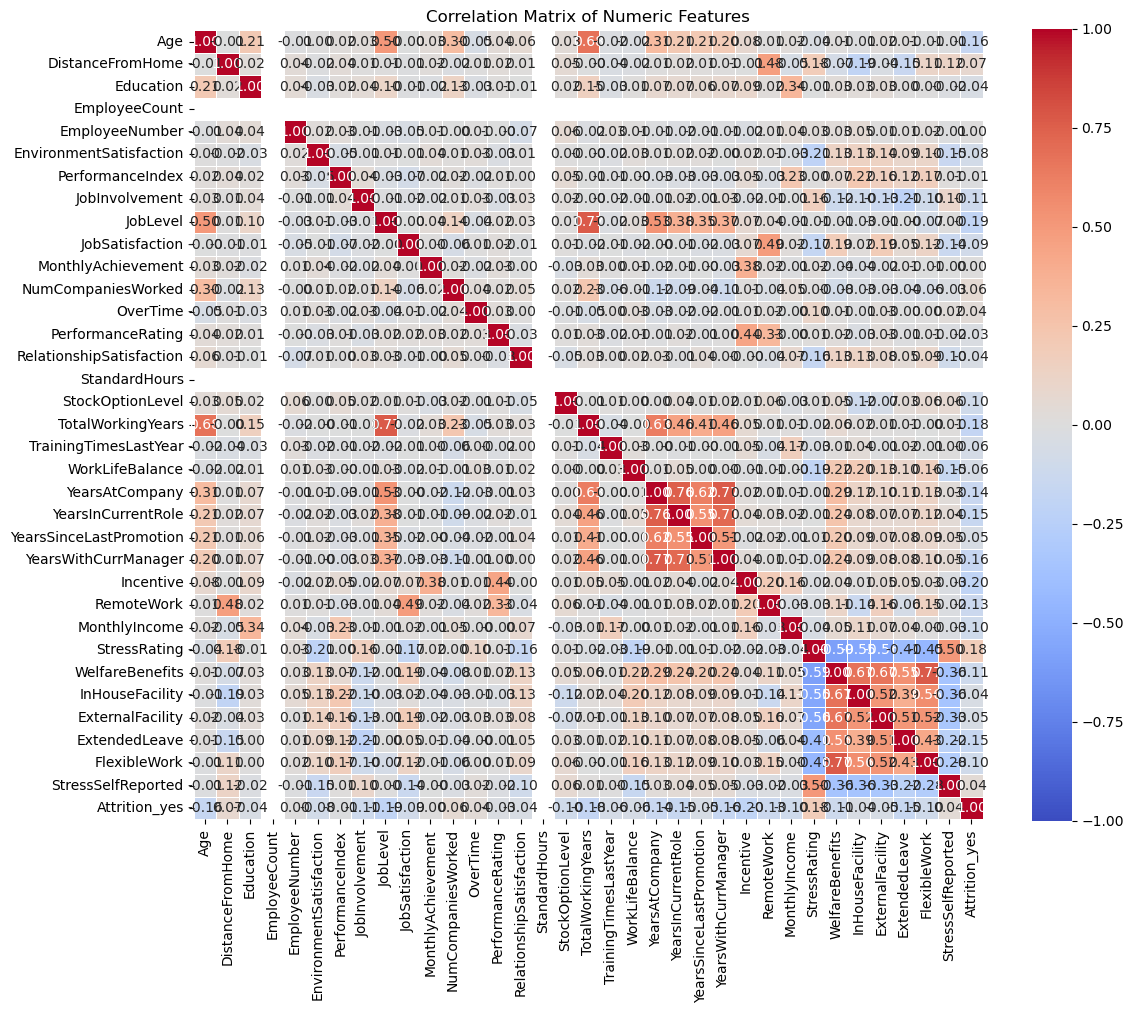

Attrition_yesと相関関係が高い上位5特徴量:
Incentive: -0.2017
JobLevel: -0.1911
StressRating: 0.1844
TotalWorkingYears: -0.1754
YearsWithCurrManager: -0.1596


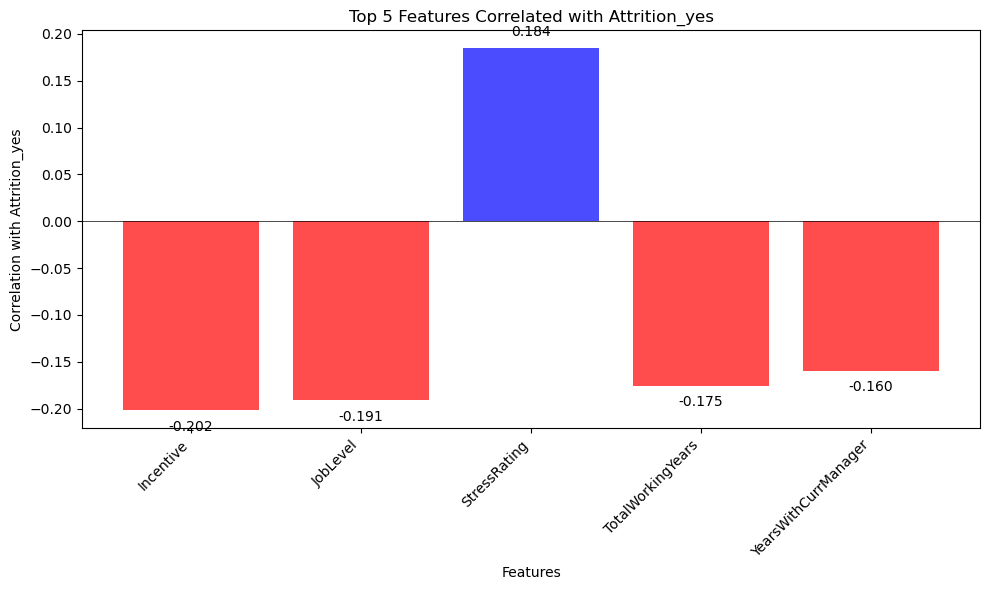

In [9]:
numeric_cols = df.select_dtypes(include=['number']).drop(['Year'], axis=1)
corr_matrix = numeric_cols.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    vmin=-1, vmax=1,
    square=True,
    linewidths=0.5
)
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

# Attrition_yesとの相関関係を計算
attrition_correlation = corr_matrix['Attrition_yes'].drop('Attrition_yes')

# 絶対値で並び替えて上位5特徴量を取得
top_5_features = attrition_correlation.abs().sort_values(ascending=False).head(5)

print("Attrition_yesと相関関係が高い上位5特徴量:")
print("="*50)
for feature, corr_value in top_5_features.items():
    actual_corr = attrition_correlation[feature]
    print(f"{feature}: {actual_corr:.4f}")

# 可視化用のバープロット
plt.figure(figsize=(10, 6))
top_5_actual = attrition_correlation[top_5_features.index]
colors = ['red' if x < 0 else 'blue' for x in top_5_actual]
bars = plt.bar(range(len(top_5_actual)), top_5_actual.values, color=colors, alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.xlabel('Features')
plt.ylabel('Correlation with Attrition_yes')
plt.title('Top 5 Features Correlated with Attrition_yes')
plt.xticks(range(len(top_5_actual)), top_5_actual.index, rotation=45, ha='right')

# 各バーに相関係数を表示
for i, (bar, value) in enumerate(zip(bars, top_5_actual.values)):
    plt.text(bar.get_x() + bar.get_width()/2, value + (0.01 if value > 0 else -0.01), 
             f'{value:.3f}', ha='center', va='bottom' if value > 0 else 'top')

plt.tight_layout()
plt.show()

カテゴリ変数と退職率の関係:


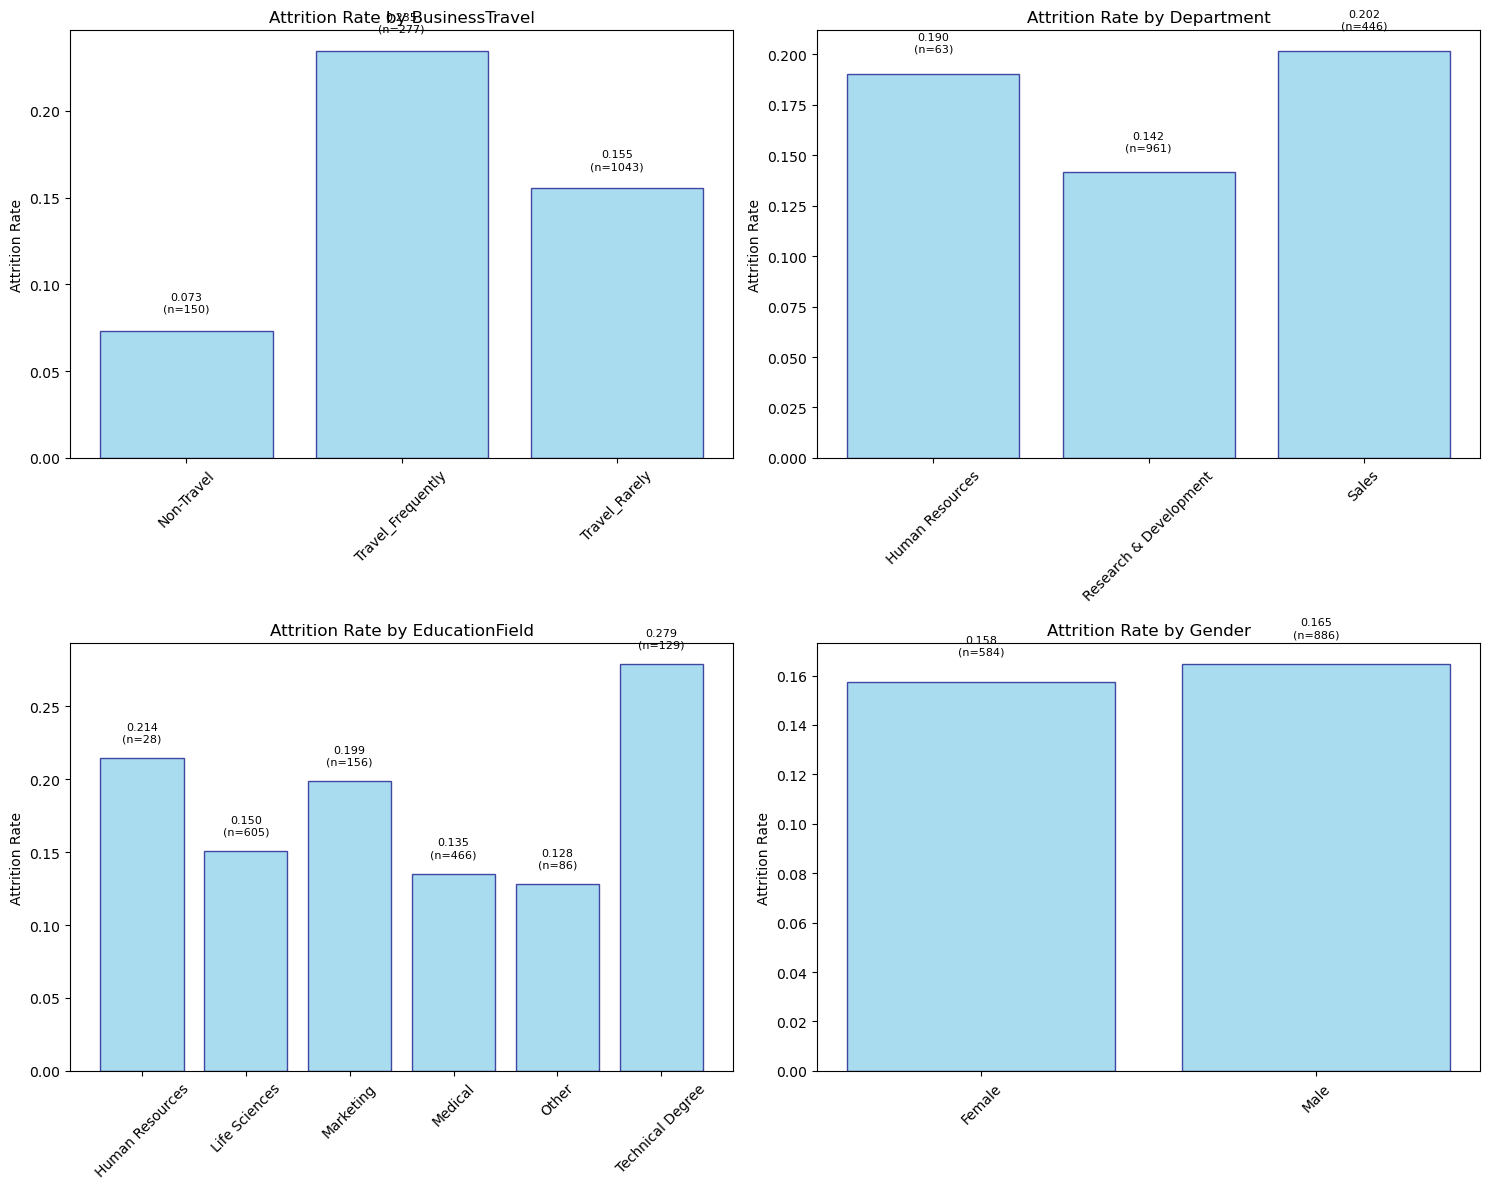

In [10]:
# カテゴリ変数と退職率の関析
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'Attrition' in categorical_cols:
    categorical_cols.remove('Attrition')  # Attritionは除外

print("カテゴリ変数と退職率の関係:")
print("="*50)

# カテゴリ変数ごとの退職率を計算・可視化
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, col in enumerate(categorical_cols[:4]):  # 最初の4つのカテゴリ変数
    if i < len(axes):
        # 退職率を計算
        attrition_by_category = df.groupby(col)['Attrition_yes'].agg(['mean', 'count']).reset_index()
        attrition_by_category.columns = [col, 'attrition_rate', 'count']
        
        # バープロット
        ax = axes[i]
        bars = ax.bar(attrition_by_category[col], attrition_by_category['attrition_rate'], 
                     alpha=0.7, color='skyblue', edgecolor='navy')
        ax.set_title(f'Attrition Rate by {col}')
        ax.set_ylabel('Attrition Rate')
        ax.tick_params(axis='x', rotation=45)
        
        # バーに値を表示
        for bar, rate, count in zip(bars, attrition_by_category['attrition_rate'], attrition_by_category['count']):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                   f'{rate:.3f}\n(n={count})', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

数値変数の分布比較（退職者 vs 非退職者）:


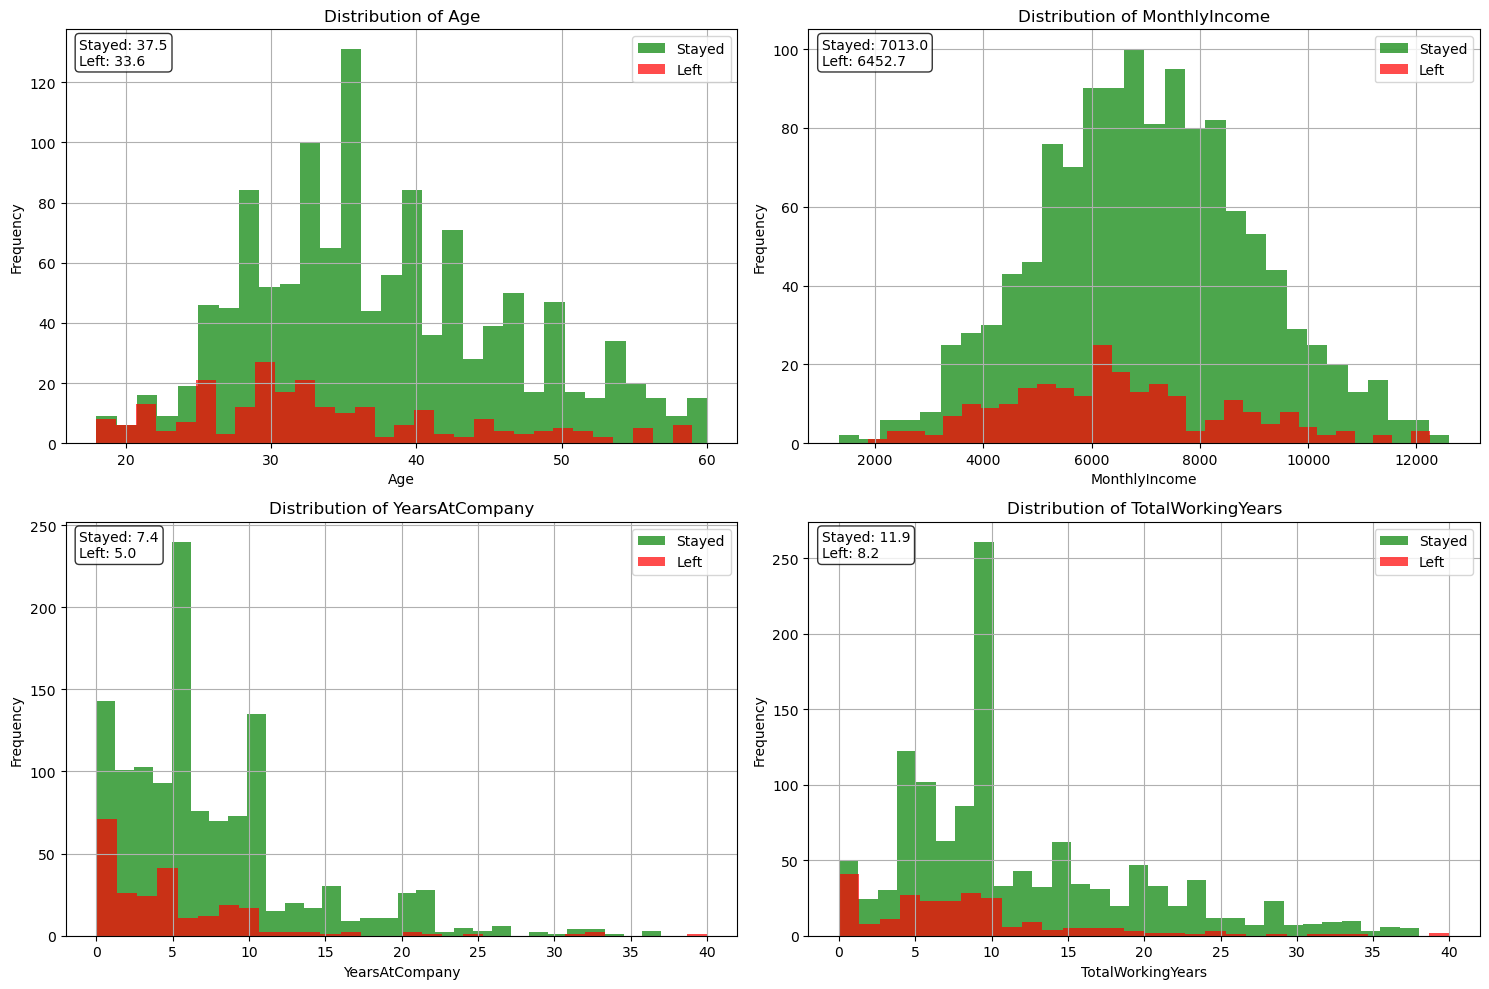

In [11]:
# 数値変数の分布比較（退職者 vs 非退職者）
print("数値変数の分布比較（退職者 vs 非退職者）:")
print("="*50)

# 主要な数値変数を選択
key_numeric_vars = ['Age', 'MonthlyIncome', 'YearsAtCompany', 'TotalWorkingYears']
available_vars = [var for var in key_numeric_vars if var in df.columns]

if len(available_vars) >= 4:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, var in enumerate(available_vars[:4]):
        ax = axes[i]
        
        # ヒストグラム
        df[df['Attrition_yes'] == 0][var].hist(alpha=0.7, bins=30, label='Stayed', 
                                               color='green', ax=ax)
        df[df['Attrition_yes'] == 1][var].hist(alpha=0.7, bins=30, label='Left', 
                                               color='red', ax=ax)
        
        ax.set_title(f'Distribution of {var}')
        ax.set_xlabel(var)
        ax.set_ylabel('Frequency')
        ax.legend()
        
        # 統計情報を表示
        stayed_mean = df[df['Attrition_yes'] == 0][var].mean()
        left_mean = df[df['Attrition_yes'] == 1][var].mean()
        ax.text(0.02, 0.98, f'Stayed: {stayed_mean:.1f}\nLeft: {left_mean:.1f}', 
               transform=ax.transAxes, va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
else:
    print("十分な数値変数が見つかりませんでした。利用可能な変数:")
    print(df.select_dtypes(include=['number']).columns.tolist())

In [12]:
# 欠損値の分析
print("欠損値の分析:")
print("="*30)
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    '欠損値数': missing_data,
    '欠損率(%)': missing_percent
}).sort_values(by='欠損値数', ascending=False)

print(missing_df[missing_df['欠損値数'] > 0])

if missing_df['欠損値数'].sum() == 0:
    print("欠損値はありません。")

# 外れ値の検出（数値変数について）
print("\n外れ値の分析（IQR法）:")
print("="*30)

numeric_columns = df.select_dtypes(include=['number']).columns
outlier_summary = []

for col in numeric_columns:
    if col != 'Year':  # Year列は除外
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_count = len(outliers)
        outlier_percent = (outlier_count / len(df)) * 100
        
        outlier_summary.append({
            '変数': col,
            '外れ値数': outlier_count,
            '外れ値率(%)': outlier_percent,
            '下限': lower_bound,
            '上限': upper_bound
        })

outlier_df = pd.DataFrame(outlier_summary).sort_values(by='外れ値数', ascending=False)
print(outlier_df)

欠損値の分析:
Empty DataFrame
Columns: [欠損値数, 欠損率(%)]
Index: []
欠損値はありません。

外れ値の分析（IQR法）:
                          変数  外れ値数    外れ値率(%)         下限         上限
34             Attrition_yes   238  16.190476      0.000      0.000
18     TrainingTimesLastYear   238  16.190476      0.500      4.500
22   YearsSinceLastPromotion   108   7.346939     -4.500      7.500
20            YearsAtCompany   104   7.074830     -6.000     18.000
16          StockOptionLevel    85   5.782313     -1.500      2.500
17         TotalWorkingYears    63   4.285714     -7.500     28.500
11        NumCompaniesWorked    52   3.537415     -3.500      8.500
27              StressRating    28   1.904762      0.500      4.500
21        YearsInCurrentRole    19   1.292517     -5.500     14.500
23      YearsWithCurrManager    14   0.952381     -5.500     14.500
12                  OverTime     9   0.612245    -23.500     52.500
26             MonthlyIncome     3   0.204082   1458.500  12348.500
24                 Incentive    

基本統計量（退職者 vs 非退職者）:
       Age_Stayed  Age_Left  Age_Difference  DistanceFromHome_Stayed  \
count     1232.00    238.00         -994.00                  1232.00   
mean        37.53     33.59           -3.94                     8.97   
std          8.91      9.68            0.77                     8.01   
min         18.00     18.00            0.00                     1.00   
25%         31.00     27.00           -4.00                     2.00   
50%         36.00     32.00           -4.00                     7.00   
75%         43.00     39.00           -4.00                    13.00   
max         60.00     59.00           -1.00                    29.00   

       DistanceFromHome_Left  DistanceFromHome_Difference  Education_Stayed  \
count                 238.00                      -994.00           1232.00   
mean                   10.62                         1.65              2.93   
std                     8.59                         0.57              1.03   
min            

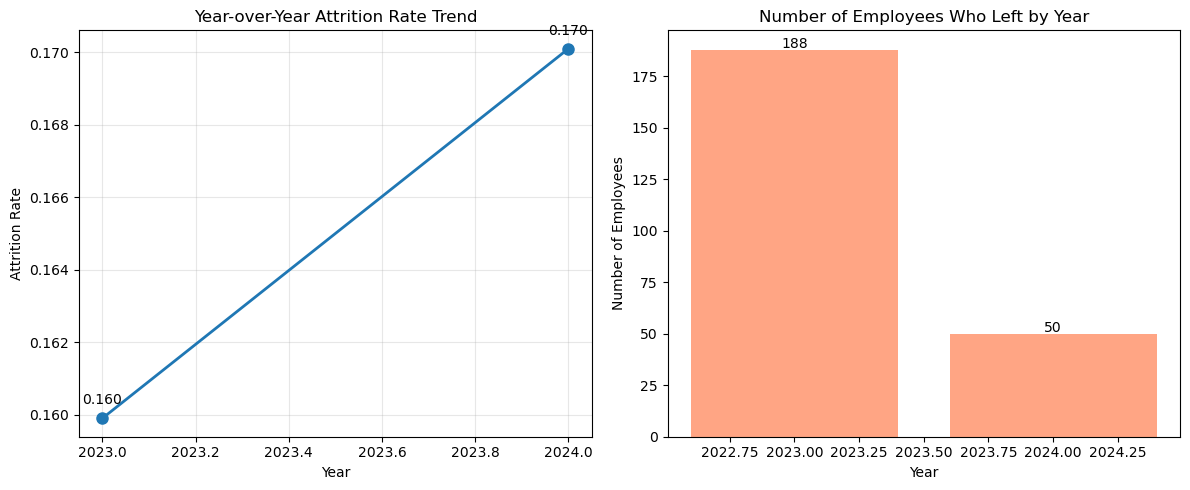

In [13]:
# 基本統計量の詳細分析
print("基本統計量（退職者 vs 非退職者）:")
print("="*40)

# 退職者と非退職者で数値変数の統計量を比較
stats_comparison = pd.DataFrame()

for col in numeric_columns:
    if col not in ['Year', 'Attrition_yes']:
        stayed_stats = df[df['Attrition_yes'] == 0][col].describe()
        left_stats = df[df['Attrition_yes'] == 1][col].describe()
        
        comparison = pd.DataFrame({
            f'{col}_Stayed': stayed_stats,
            f'{col}_Left': left_stats,
            f'{col}_Difference': left_stats - stayed_stats
        })
        
        if stats_comparison.empty:
            stats_comparison = comparison
        else:
            stats_comparison = pd.concat([stats_comparison, comparison], axis=1)

print(stats_comparison.round(2))

# 年度別トレンド分析
if 'Year' in df.columns:
    print("\n年度別退職率のトレンド:")
    print("="*25)
    
    yearly_attrition = df.groupby('Year').agg({
        'Attrition_yes': ['mean', 'sum', 'count']
    }).round(4)
    yearly_attrition.columns = ['退職率', '退職者数', '総従業員数']
    print(yearly_attrition)
    
    # 年度別トレンドの可視化
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(yearly_attrition.index, yearly_attrition['退職率'], marker='o', linewidth=2, markersize=8)
    plt.title('Year-over-Year Attrition Rate Trend')
    plt.xlabel('Year')
    plt.ylabel('Attrition Rate')
    plt.grid(True, alpha=0.3)
    
    # 値をラベルとして表示
    for year, rate in zip(yearly_attrition.index, yearly_attrition['退職率']):
        plt.annotate(f'{rate:.3f}', (year, rate), textcoords="offset points", 
                    xytext=(0,10), ha='center')
    
    plt.subplot(1, 2, 2)
    plt.bar(yearly_attrition.index, yearly_attrition['退職者数'], alpha=0.7, color='coral')
    plt.title('Number of Employees Who Left by Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Employees')
    
    # 値をバーに表示
    for year, count in zip(yearly_attrition.index, yearly_attrition['退職者数']):
        plt.text(year, count + 1, str(int(count)), ha='center')
    
    plt.tight_layout()
    plt.show()

ボックスプロットによる数値変数の分布比較:


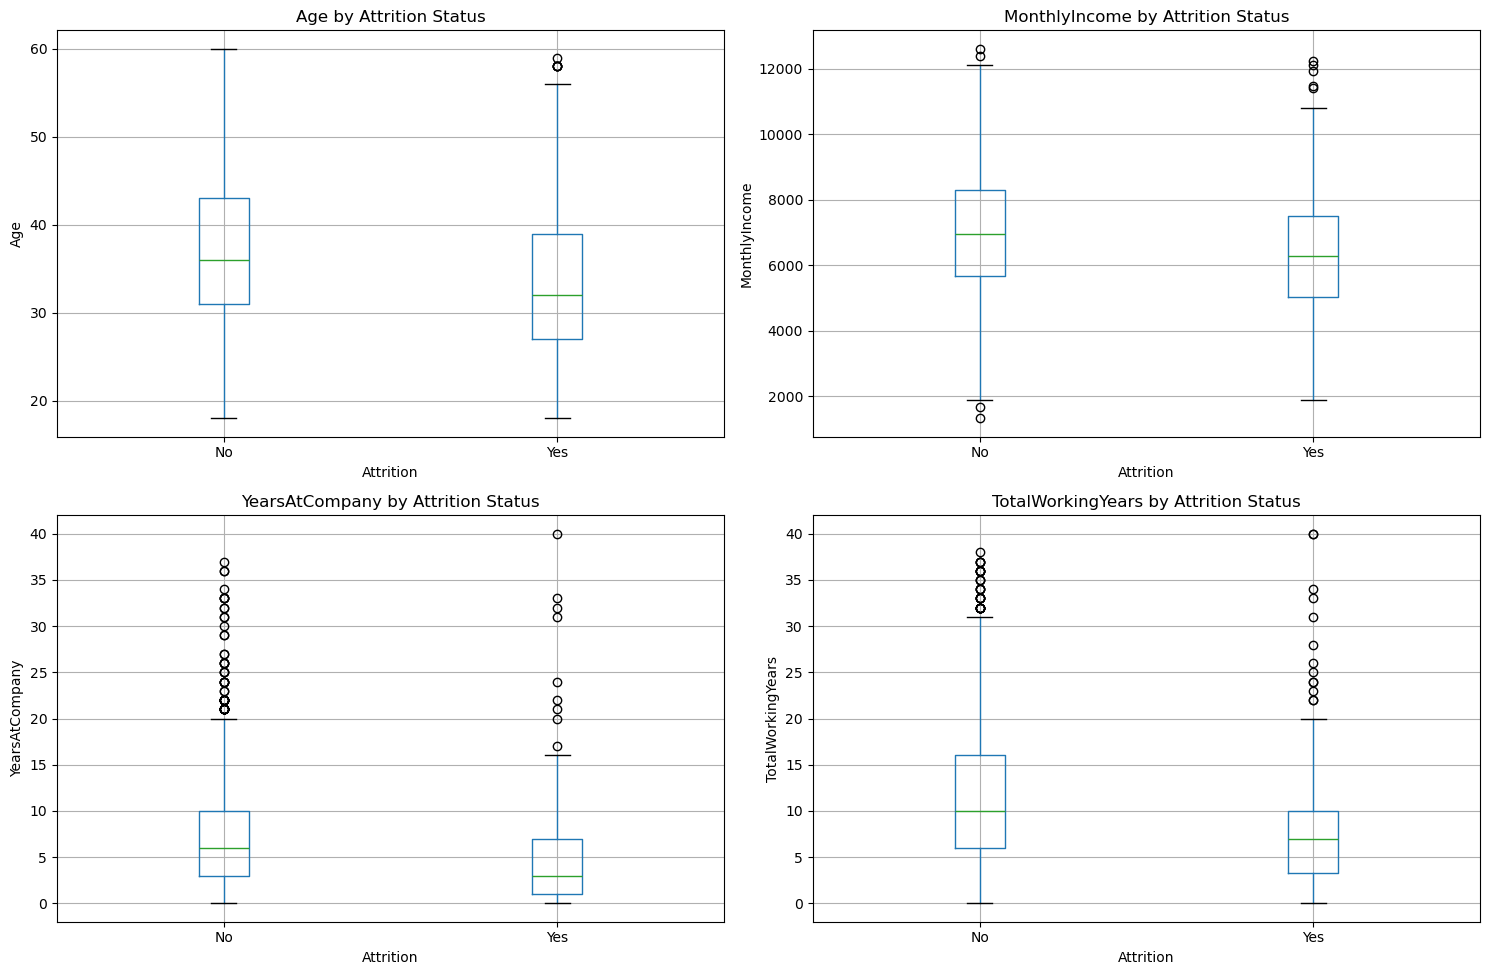


主要変数間の関係（散布図マトリックス）:


<Figure size 1200x1000 with 0 Axes>

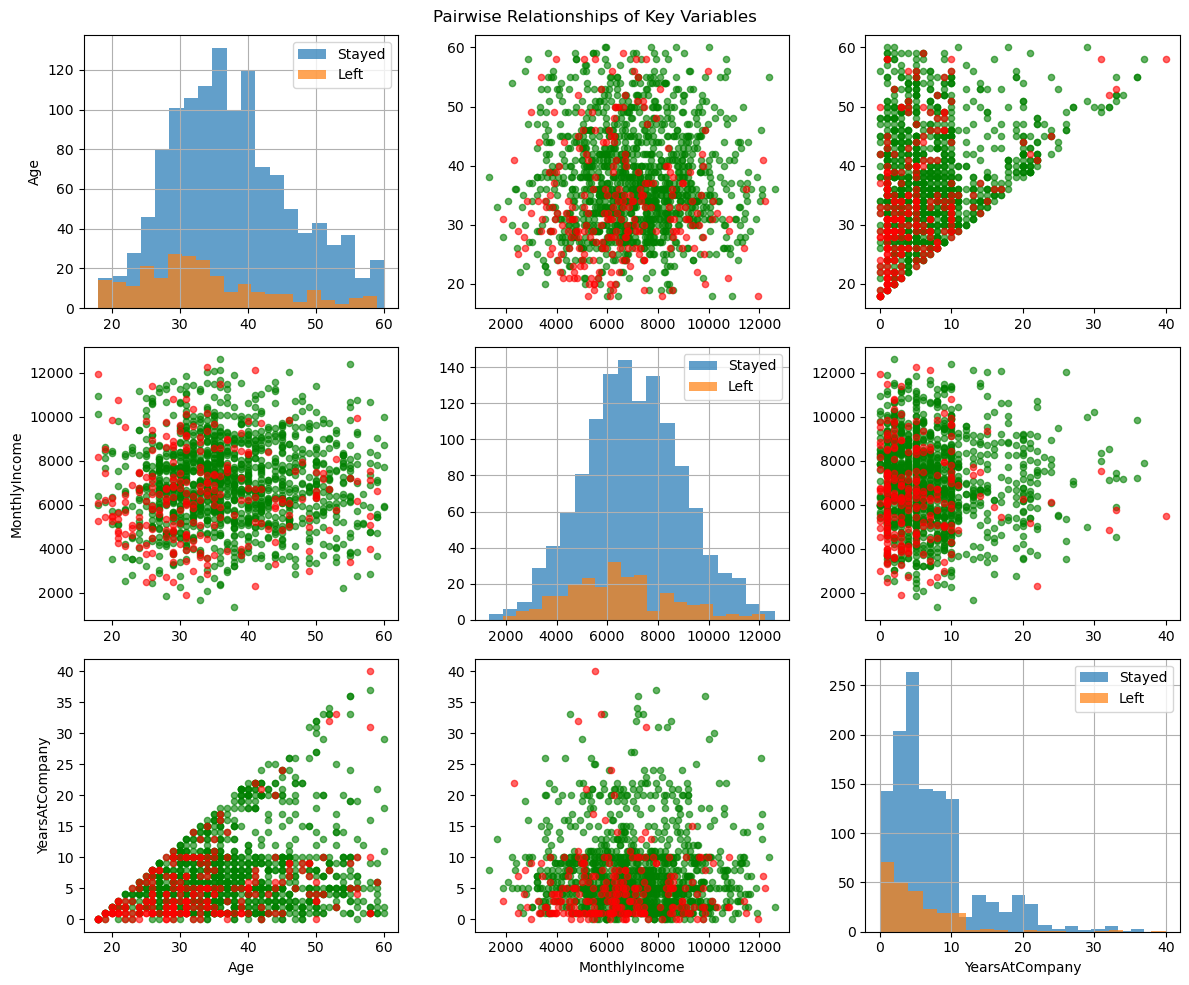

In [14]:
# ボックスプロットによる分布の比較
print("ボックスプロットによる数値変数の分布比較:")
print("="*45)

if len(available_vars) >= 4:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, var in enumerate(available_vars[:4]):
        ax = axes[i]
        
        # ボックスプロット
        df.boxplot(column=var, by='Attrition', ax=ax)
        ax.set_title(f'{var} by Attrition Status')
        ax.set_xlabel('Attrition')
        ax.set_ylabel(var)
    
    plt.suptitle('')  # 自動タイトルを削除
    plt.tight_layout()
    plt.show()

# 散布図マトリックス（主要変数間の関係）
print("\n主要変数間の関係（散布図マトリックス）:")
print("="*40)

if len(available_vars) >= 3:
    # 主要な3-4変数を選択
    key_vars = available_vars[:3] + ['Attrition_yes']
    
    plt.figure(figsize=(12, 10))
    
    # ペアプロット風の散布図
    n_vars = len(key_vars) - 1  # Attrition_yesを除く
    fig, axes = plt.subplots(n_vars, n_vars, figsize=(12, 10))
    
    for i in range(n_vars):
        for j in range(n_vars):
            ax = axes[i, j] if n_vars > 1 else axes
            
            if i == j:
                # 対角線：ヒストグラム
                df[df['Attrition_yes'] == 0][key_vars[i]].hist(alpha=0.7, bins=20, 
                                                               label='Stayed', ax=ax)
                df[df['Attrition_yes'] == 1][key_vars[i]].hist(alpha=0.7, bins=20, 
                                                               label='Left', ax=ax)
                ax.legend()
            else:
                # 散布図
                stayed = df[df['Attrition_yes'] == 0]
                left = df[df['Attrition_yes'] == 1]
                
                ax.scatter(stayed[key_vars[j]], stayed[key_vars[i]], 
                          alpha=0.6, s=20, label='Stayed', color='green')
                ax.scatter(left[key_vars[j]], left[key_vars[i]], 
                          alpha=0.6, s=20, label='Left', color='red')
                
                if i == 0 and j == 0:  # 最初の散布図にのみ凡例を表示
                    ax.legend()
            
            # ラベルを設定
            if i == n_vars - 1:
                ax.set_xlabel(key_vars[j])
            if j == 0:
                ax.set_ylabel(key_vars[i])
    
    plt.suptitle('Pairwise Relationships of Key Variables')
    plt.tight_layout()
    plt.show()

優秀さを示すカテゴリ指標と退職率の関係:


C:\Users\user\AppData\Local\Temp\ipykernel_2572\896682318.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=col, y='Attrition_yes', data=attrition_rate, ax=ax,
C:\Users\user\AppData\Local\Temp\ipykernel_2572\896682318.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=col, y='Attrition_yes', data=attrition_rate, ax=ax,
C:\Users\user\AppData\Local\Temp\ipykernel_2572\896682318.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=col, y='Attrition_yes', data=attrition_rate, ax=ax,


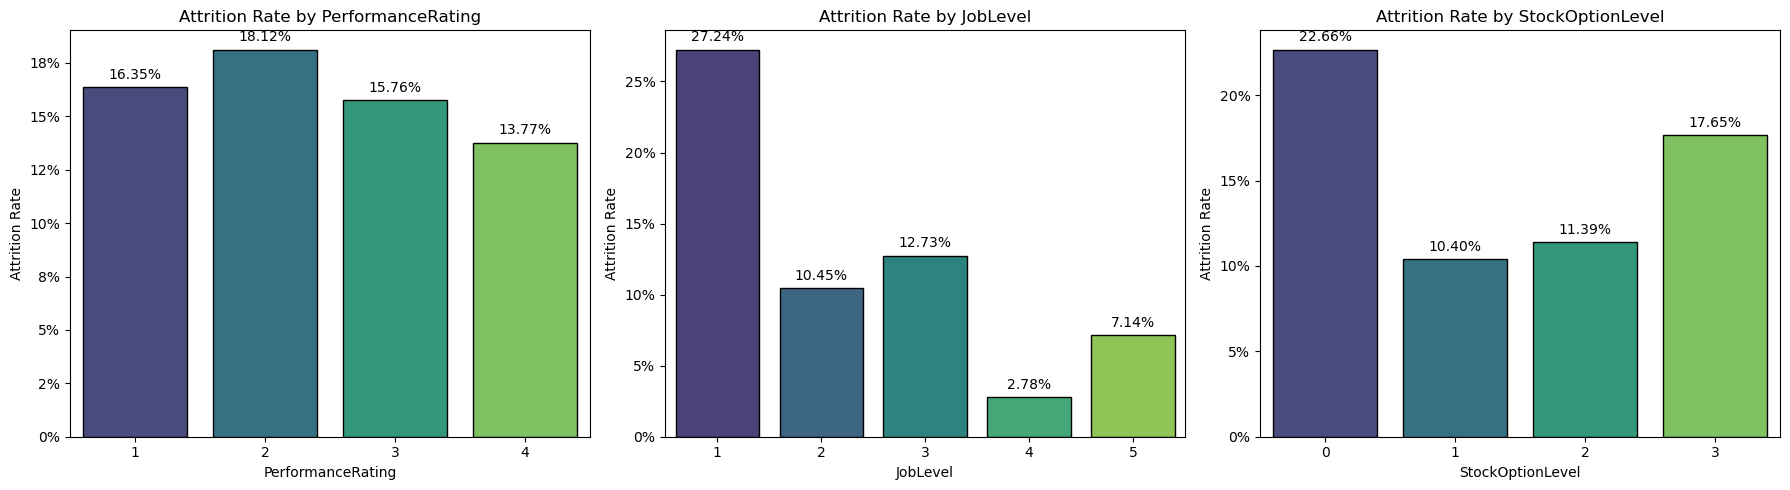

In [15]:
# --- 優秀さを示す指標と退職の関係を分析 ---

# 1. カテゴリ的な指標と退職率の関係
print("優秀さを示すカテゴリ指標と退職率の関係:")
print("="*50)

# 分析対象のカテゴリ変数
excellence_cat_vars = ['PerformanceRating', 'JobLevel', 'StockOptionLevel']

# グラフ描画
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes = axes.ravel()

for i, col in enumerate(excellence_cat_vars):
    # 退職率を計算
    attrition_rate = df.groupby(col)['Attrition_yes'].mean().reset_index()
    
    # バープロット
    ax = axes[i]
    bars = sns.barplot(x=col, y='Attrition_yes', data=attrition_rate, ax=ax, 
                       palette='viridis', edgecolor='black')
    
    ax.set_title(f'Attrition Rate by {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Attrition Rate')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) # y軸をパーセント表示に
    
    # バーに値を表示
    for p in bars.patches:
        ax.annotate(f'{p.get_height():.2%}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points')

plt.tight_layout()
plt.show()


優秀さを示す連続値指標と退職の関係:


C:\Users\user\AppData\Local\Temp\ipykernel_2572\3953646999.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Attrition', y=col, data=df, ax=ax, palette='Set2')
C:\Users\user\AppData\Local\Temp\ipykernel_2572\3953646999.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Attrition', y=col, data=df, ax=ax, palette='Set2')
C:\Users\user\AppData\Local\Temp\ipykernel_2572\3953646999.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Attrition', y=col, data=df, ax=ax, palette='Set2')
C:\Users\user\AppData\Local\Temp\ipykernel_2572\3

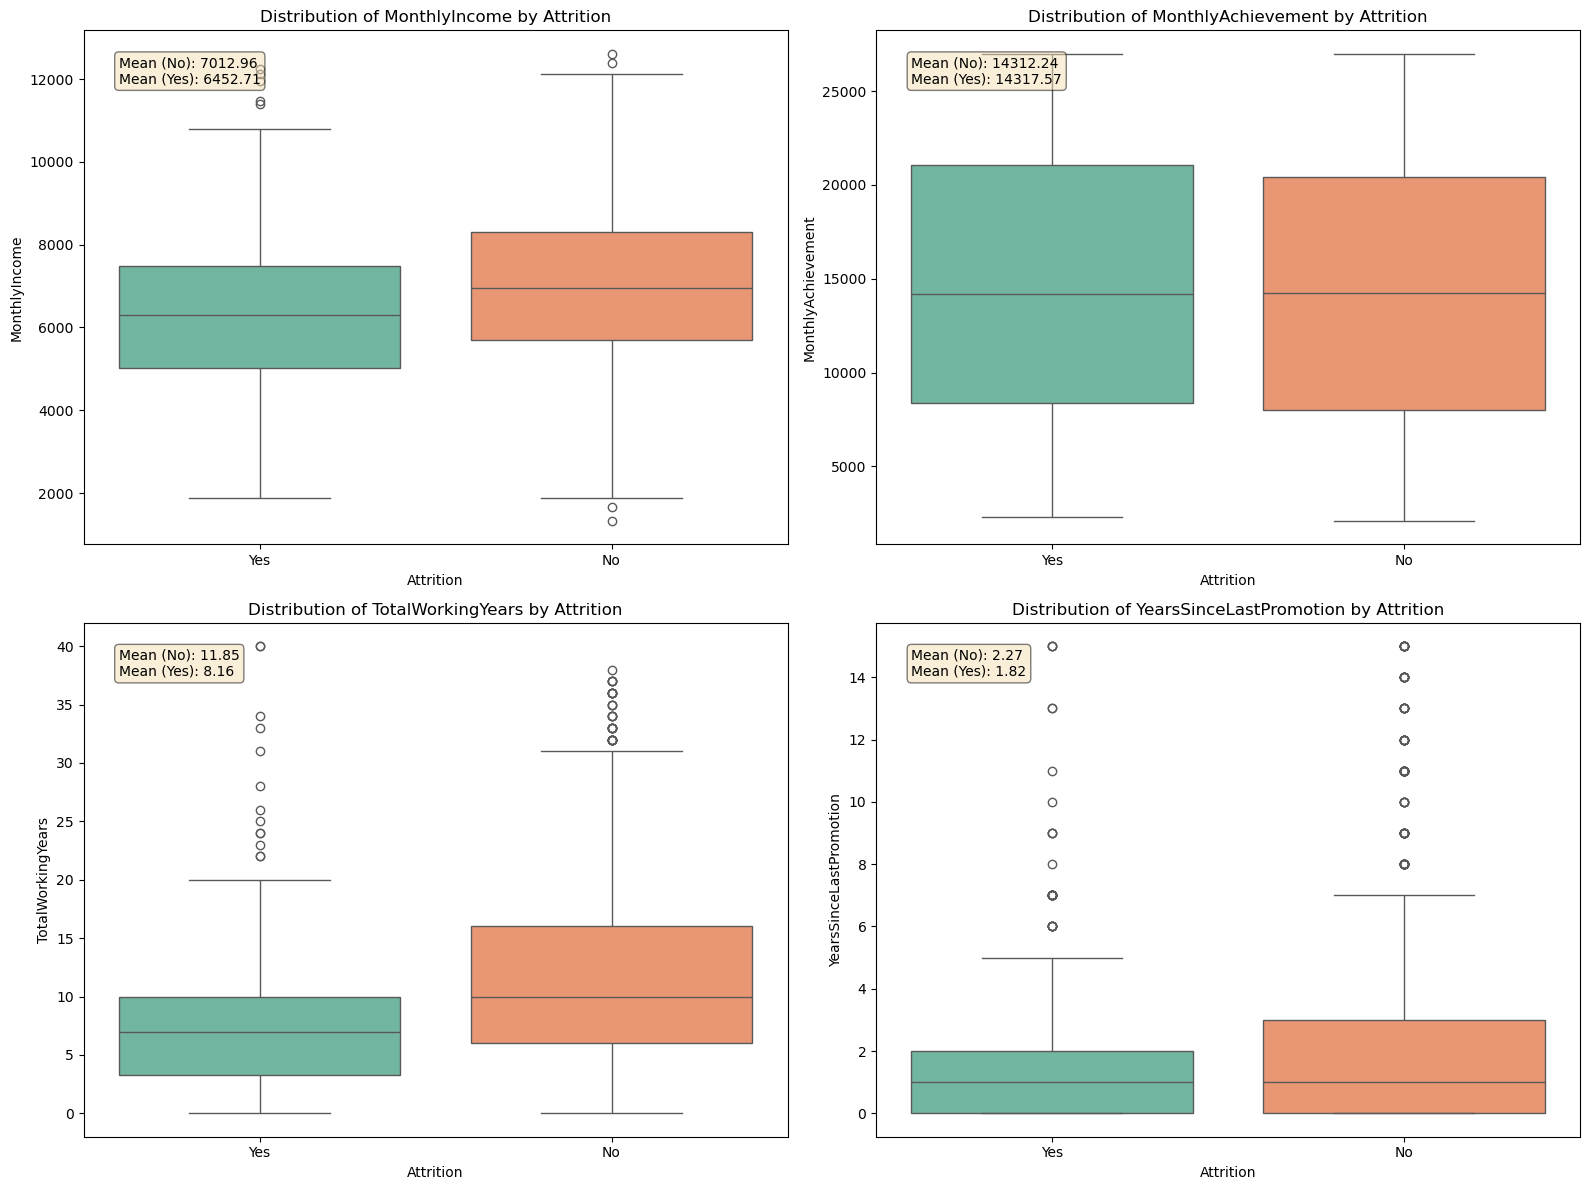

In [20]:
# 2. 連続値の指標と退職の関係
print("\n優秀さを示す連続値指標と退職の関係:")
print("="*50)

# 分析対象の連続値変数
# Replace 'PercentSalaryHike' with an existing column name, e.g., 'MonthlyAchievement'
excellence_num_vars = ['MonthlyIncome', 'MonthlyAchievement', 'TotalWorkingYears', 'YearsSinceLastPromotion']

# グラフ描画
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, col in enumerate(excellence_num_vars):
    ax = axes[i]
    
    # ボックスプロット
    sns.boxplot(x='Attrition', y=col, data=df, ax=ax, palette='Set2')
    ax.set_title(f'Distribution of {col} by Attrition')
    ax.set_xlabel('Attrition')
    ax.set_ylabel(col)
    
    # 平均値を計算して表示
    means = df.groupby('Attrition')[col].mean()
    ax.text(0.05, 0.95, f"Mean (No): {means['No']:.2f}\nMean (Yes): {means['Yes']:.2f}",
            transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

職種（JobRole）一覧:
JobRole
Sales Executive              328
Research Scientist           291
Laboratory Technician        259
Manufacturing Director       145
Healthcare Representative    133
Manager                      101
Sales Representative          82
Research Director             79
Human Resources               52
Name: count, dtype: int64

パフォーマンス評価（PerformanceRating）の分布:
PerformanceRating
1    263
2    436
3    495
4    276
Name: count, dtype: int64

各グループの離職率と従業員数:
                          Group  Attrition Rate  Number of Employees
0                 All Employees        0.161905                 1470
1                   Researchers        0.205455                  550
2         Young Employees (<35)        0.230534                  655
3  Promising Employees (Perf=4)        0.137681                  276
4       Young Researchers (<35)        0.268371                  313
5   Promising Young Researchers        0.288462                   52


C:\Users\user\AppData\Local\Temp\ipykernel_2572\3989035189.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Attrition Rate', y='Group', data=plot_data, palette='plasma', edgecolor='black')


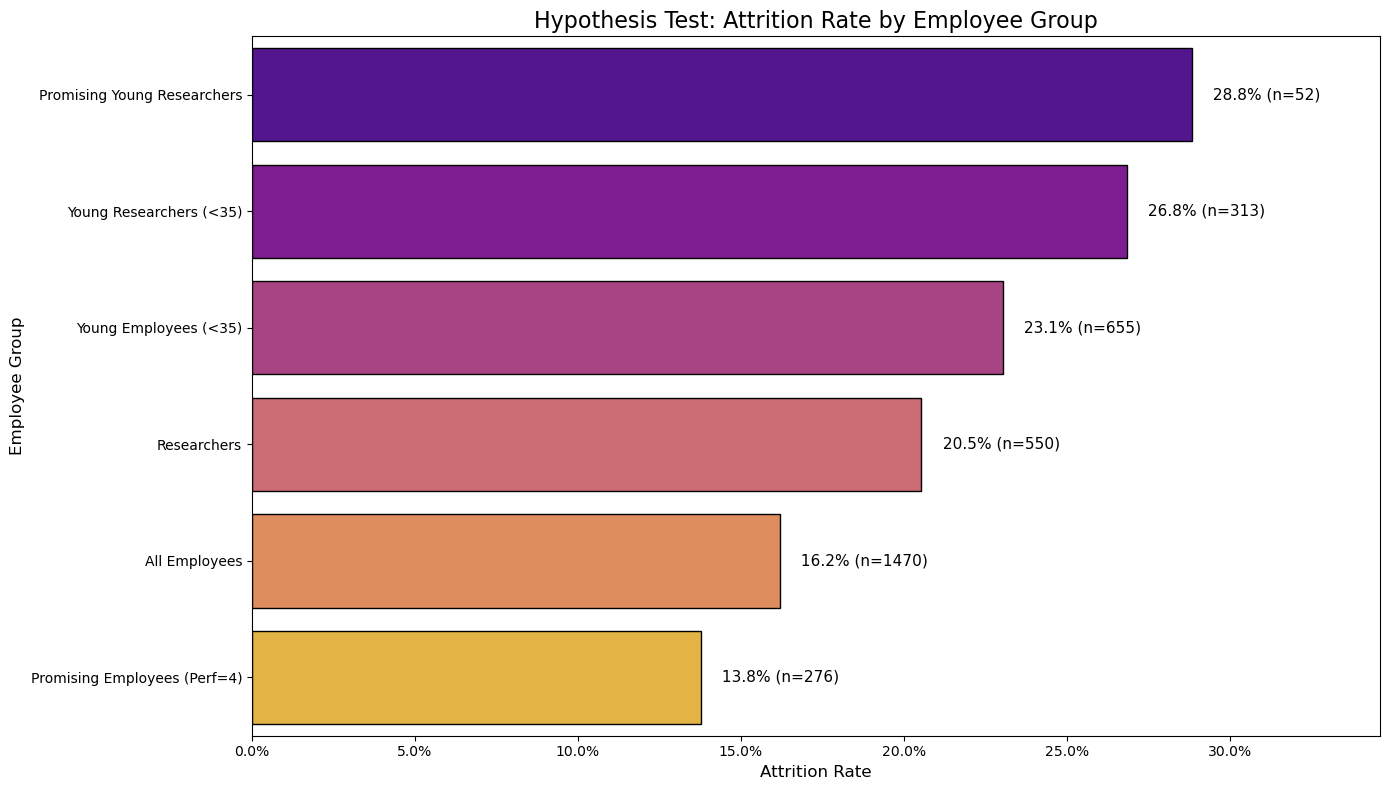

In [21]:
# --- 仮説検証：有望な若手研究員の離職率は高いか？ ---

# まず、分析に必要なカラムのカテゴリを確認
print("職種（JobRole）一覧:")
print(df['JobRole'].value_counts())
print("="*50)
print("\nパフォーマンス評価（PerformanceRating）の分布:")
print(df['PerformanceRating'].value_counts().sort_index())
print("="*50)

# 1. 対象者を定義
# 「研究員」: Research Scientist または Laboratory Technician
# 「若手」: 35歳未満
# 「有望」: PerformanceRating が 4
researchers = df[df['JobRole'].isin(['Research Scientist', 'Laboratory Technician'])]
young_employees = df[df['Age'] < 35]
promising_employees = df[df['PerformanceRating'] == 4]
young_researchers = df[(df['JobRole'].isin(['Research Scientist', 'Laboratory Technician'])) & (df['Age'] < 35)]
promising_young_researchers = df[(df['JobRole'].isin(['Research Scientist', 'Laboratory Technician'])) & (df['Age'] < 35) & (df['PerformanceRating'] == 4)]

# 2. 各グループの離職率と人数を計算
groups = {
    'All Employees': df,
    'Researchers': researchers,
    'Young Employees (<35)': young_employees,
    'Promising Employees (Perf=4)': promising_employees,
    'Young Researchers (<35)': young_researchers,
    'Promising Young Researchers': promising_young_researchers
}

results_list = []
for name, group_df in groups.items():
    count = len(group_df)
    attrition_rate = group_df['Attrition_yes'].mean() if count > 0 else 0
    results_list.append({
        'Group': name,
        'Attrition Rate': attrition_rate,
        'Number of Employees': count
    })

results_df = pd.DataFrame(results_list)

print("\n各グループの離職率と従業員数:")
print(results_df)
print("="*50)

# 3. 可視化
# 人数が0のグループはプロットから除外
plot_data = results_df[results_df['Number of Employees'] > 0].sort_values('Attrition Rate', ascending=False)

plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Attrition Rate', y='Group', data=plot_data, palette='plasma', edgecolor='black')

# グラフの装飾
ax.set_title('Hypothesis Test: Attrition Rate by Employee Group', fontsize=16)
ax.set_xlabel('Attrition Rate', fontsize=12)
ax.set_ylabel('Employee Group', fontsize=12)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1%}'))
plt.xlim(0, max(plot_data['Attrition Rate']) * 1.2)

# バーに数値を表示
for i, (rate, count) in enumerate(zip(plot_data['Attrition Rate'], plot_data['Number of Employees'])):
    ax.text(rate + 0.005, i, f' {rate:.1%} (n={count})', 
            color='black', va='center', ha='left', fontsize=11)

plt.tight_layout()
plt.show()